# Identifying planning discourse markers

The goal of this notebook is to replicate work on identifying planning discourse markers in the Enron Email Dataset following an approach outlined in Niculae et al (2015).

The paper is available here: https://vene.ro/betrayal/niculae15betrayal.pdf

We begin by working with a sample of the Enron Email dataset that we have previously extracted.

In [1]:
import os
import sys
import pyprojroot
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag, ne_chunk
from nltk.tree import Tree

proj_root = pyprojroot.find_root(pyprojroot.has_file(".git"))
sys.path.append(os.path.join(proj_root, 'code'))
nltk.data.path.append(os.path.join(proj_root, "data/nltk_data"))

from utils import parallel_apply

In [2]:
norm_email_path = os.path.join(proj_root, 'notebooks/David/norm_emails.csv')
norm_emails = pd.read_csv(norm_email_path)

exec_email_path = os.path.join(proj_root, 'data/from_david/exec_emails.csv')
exec_emails = pd.read_csv(exec_email_path)

poi_email_path = os.path.join(proj_root, 'data/from_david/poi_emails.csv')
poi_emails = pd.read_csv(poi_email_path)

In [3]:
enron_emails = []
for dataset, emails in zip(['norm', 'exec', 'poi'], [norm_emails, exec_emails, poi_emails]):
    emails.loc[:, 'dataset'] = dataset
    enron_emails.append(emails)
enron_emails = pd.concat(enron_emails)
enron_emails

,Original Index,Email,Sender,POI,Exec 200,Exec 300,Date,Classify Email,dataset,Politeness,Politeness Score
0,115,Enjoy!\n,Davis,False,False,False,"Wed, 24 Oct 2001 05:09:25 -0700 (PDT)",Enjoy!,norm,NaN,NaN
1,661,Gold Rose today?,Davis,False,False,False,"Wed, 7 Nov 2001 04:58:24 -0800 (PST)",Apple today?,norm,NaN,NaN
2,773,Lisa Bills and I spoke concerning this transac...,Shackleton,False,False,False,"Fri, 26 Oct 2001 10:54:15 -0700 (PDT)","Steve and I spoke concerning this transaction,...",norm,NaN,NaN
3,810,How about meeting in advance of tomorrow's 130...,Shackleton,False,False,False,"Mon, 1 Oct 2001 11:24:07 -0700 (PDT)",How about meeting in advance of tomorrow's 130...,norm,NaN,NaN
4,866,"Kay, Hancock has delivered a revised letter th...",Jones,False,False,False,"Fri, 26 Oct 2001 15:50:48 -0700 (PDT)","Steve, Apple has delivered a revised letter th...",norm,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1104,499674,"Greg, as per your request - \t*2001 bonus num...",Delainey,True,True,True,"Thu, 8 Nov 2001 09:20:48","Greg, as per your request - *2001 bonus number...",poi,0.0,0.204643
1105,499934,"Kevin, given the track record of mis-behaviour...",Delainey,True,True,True,"Mon, 22 Oct 2001 10:33:44","Steve, given the track record of mis-behaviour...",poi,0.0,0.201780
1106,500742,"fyi, on a different note, given legislative ap...",Delainey,True,True,True,"Wed, 16 May 2001 01:47:00","fyi, on a different note, given legislative ap...",poi,0.0,0.198619
1107,516194,"HA HA HA YOU STUPID, ARROGANT FUCK ___________...",Skilling,True,True,True,"Fri, 30 Nov 2001 15:34:35","HA HA HA YOU STUPID, ARROGANT FUCK ___________...",poi,0.0,0.096003


In [4]:
def find_planning_markers(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    
    # Extended set of individual markers
    individual_markers = {'shall', 'going', 'planning', 'intend', 'aim', 'hope', 'expect'}
    phrasal_markers = [
        ('plan', 'to'), ('aim', 'to'), ('going', 'to'), 
        ('looking', 'forward'), ('in', 'preparation'), ('prepare', 'for'),
    ]

    markers_found = []

    # Search for individual markers
    for word, tag in tagged:
        w = word.lower()
        if w in individual_markers:
            markers_found.append(w)

    # Search for phrasal constructs
    for i in range(len(tagged) - 1):
        pair = (tagged[i][0].lower(), tagged[i + 1][0].lower())
        if pair in phrasal_markers:
            markers_found.append(' '.join(pair))

    return markers_found

# Example usage
text = "We will plan to launch the new product next month."
find_planning_markers(text)


['plan to']

In [5]:
enron_emails

,Original Index,Email,Sender,POI,Exec 200,Exec 300,Date,Classify Email,dataset,Politeness,Politeness Score
0,115,Enjoy!\n,Davis,False,False,False,"Wed, 24 Oct 2001 05:09:25 -0700 (PDT)",Enjoy!,norm,NaN,NaN
1,661,Gold Rose today?,Davis,False,False,False,"Wed, 7 Nov 2001 04:58:24 -0800 (PST)",Apple today?,norm,NaN,NaN
2,773,Lisa Bills and I spoke concerning this transac...,Shackleton,False,False,False,"Fri, 26 Oct 2001 10:54:15 -0700 (PDT)","Steve and I spoke concerning this transaction,...",norm,NaN,NaN
3,810,How about meeting in advance of tomorrow's 130...,Shackleton,False,False,False,"Mon, 1 Oct 2001 11:24:07 -0700 (PDT)",How about meeting in advance of tomorrow's 130...,norm,NaN,NaN
4,866,"Kay, Hancock has delivered a revised letter th...",Jones,False,False,False,"Fri, 26 Oct 2001 15:50:48 -0700 (PDT)","Steve, Apple has delivered a revised letter th...",norm,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1104,499674,"Greg, as per your request - \t*2001 bonus num...",Delainey,True,True,True,"Thu, 8 Nov 2001 09:20:48","Greg, as per your request - *2001 bonus number...",poi,0.0,0.204643
1105,499934,"Kevin, given the track record of mis-behaviour...",Delainey,True,True,True,"Mon, 22 Oct 2001 10:33:44","Steve, given the track record of mis-behaviour...",poi,0.0,0.201780
1106,500742,"fyi, on a different note, given legislative ap...",Delainey,True,True,True,"Wed, 16 May 2001 01:47:00","fyi, on a different note, given legislative ap...",poi,0.0,0.198619
1107,516194,"HA HA HA YOU STUPID, ARROGANT FUCK ___________...",Skilling,True,True,True,"Fri, 30 Nov 2001 15:34:35","HA HA HA YOU STUPID, ARROGANT FUCK ___________...",poi,0.0,0.096003


In [6]:
enron_emails['Planning Markers'] = parallel_apply(enron_emails['Classify Email'], find_planning_markers)

Processing:   0%|          | 0/32 [00:00<?, ?it/s]

In [7]:
enron_emails['Num Planning Markers'] = enron_emails['Planning Markers'].apply(len)

In [8]:
enron_emails['Sentences'] = parallel_apply(enron_emails['Classify Email'], sent_tokenize)
enron_emails['Num Sentences'] = enron_emails.Sentences.apply(len)

Processing:   0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
enron_emails['Planning Markers'].explode().dropna().value_counts()

Planning Markers
going              4396
hope               2829
going to           2482
shall              2319
expect             1192
plan to            1059
planning            949
looking forward     255
intend              185
in preparation      150
prepare for          96
aim                  83
aim to               24
Name: count, dtype: int64

In [ ]:
enron_emails.loc[enron_emails['Num Planning Markers'] > 0, ['Planning Markers', 'Email']]

In [10]:
date_format = "%a, %d %b %Y %H:%M:%S "

# Set the 'date' column as the index
enron_emails['Date'] = pd.to_datetime(
    enron_emails["Date"].apply(lambda x: x.split("-")[0]),
    format=date_format,
    errors="coerce"
)
enron_emails.set_index('Date', inplace=True)

In [11]:
monthly_sentence_count = enron_emails.groupby('dataset').resample('M')['Num Sentences'].sum()
monthly_planning_marker_count = enron_emails.groupby('dataset').resample('M')['Num Planning Markers'].sum()

monthly_planning_markers_per_sentence = monthly_planning_marker_count / monthly_sentence_count

In [12]:
monthly_planning_markers_per_sentence

dataset  Date      
exec     1999-03-31    0.000000
         1999-04-30         NaN
         1999-05-31    0.022222
         1999-06-30    0.000000
         1999-07-31    0.024000
                         ...   
poi      2001-09-30    0.023674
         2001-10-31    0.022561
         2001-11-30    0.024823
         2001-12-31    0.018908
         2002-01-31    0.015385
Length: 102, dtype: float64

In [13]:
monthly_planning_markers_per_sentence = monthly_planning_markers_per_sentence.to_frame().reset_index()
monthly_planning_markers_per_sentence.columns = ['Dataset', 'Date', 'Value']
monthly_planning_markers_per_sentence

,Dataset,Date,Value
0,exec,1999-03-31,0.000000
1,exec,1999-04-30,NaN
2,exec,1999-05-31,0.022222
3,exec,1999-06-30,0.000000
4,exec,1999-07-31,0.024000
...,...,...,...
97,poi,2001-09-30,0.023674
98,poi,2001-10-31,0.022561
99,poi,2001-11-30,0.024823
100,poi,2001-12-31,0.018908


In [14]:
import calendar
monthly_planning_markers_per_sentence['Month'] = monthly_planning_markers_per_sentence.Date.apply(lambda x: calendar.month_abbr[x.month])
monthly_planning_markers_per_sentence['Year'] = monthly_planning_markers_per_sentence.Date.apply(lambda x: x.year)

In [15]:
monthly_planning_markers_per_sentence

,Dataset,Date,Value,Month,Year
0,exec,1999-03-31,0.000000,Mar,1999
1,exec,1999-04-30,NaN,Apr,1999
2,exec,1999-05-31,0.022222,May,1999
3,exec,1999-06-30,0.000000,Jun,1999
4,exec,1999-07-31,0.024000,Jul,1999
...,...,...,...,...,...
97,poi,2001-09-30,0.023674,Sep,2001
98,poi,2001-10-31,0.022561,Oct,2001
99,poi,2001-11-30,0.024823,Nov,2001
100,poi,2001-12-31,0.018908,Dec,2001


In [16]:
# Convert 'Year' and 'Month' to strings if they aren't already
monthly_planning_markers_per_sentence['Year'] = monthly_planning_markers_per_sentence['Year'].astype(str)
monthly_planning_markers_per_sentence['Month'] = monthly_planning_markers_per_sentence['Month'].astype(str)

# Create an ordered CategoricalDtype for months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_type = pd.CategoricalDtype(categories=month_order, ordered=True)

# Convert 'Month' to ordered categorical type
monthly_planning_markers_per_sentence['Month'] = monthly_planning_markers_per_sentence['Month'].astype(month_type)

In [17]:
# Now pivot your DataFrame
monthly_planning_markers_per_sentence = monthly_planning_markers_per_sentence.pivot(index=['Year', 'Month'], columns='Dataset', values='Value')

In [18]:
monthly_planning_markers_per_sentence.to_csv('monthly_planning_markers_per_sentence.csv', index=False)

<Axes: title={'center': 'Planning discourse markers in the Enron emails'}, xlabel='Time (Year, Month)', ylabel='Average planning discourse markers per sentence (%)'>

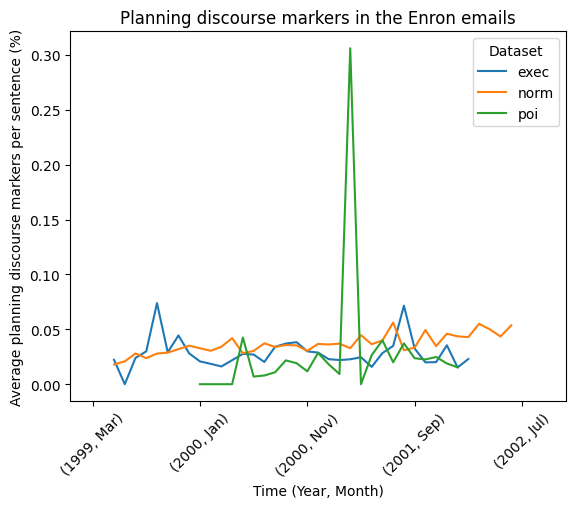

In [19]:
xlabel="Time (Year, Month)"
ylabel="Average planning discourse markers per sentence (%)"
title="Planning discourse markers in the Enron emails"
monthly_planning_markers_per_sentence.plot(xlabel=xlabel, ylabel=ylabel, rot=45, title=title)

In [20]:
enron_emails = enron_emails.reset_index()

start_date = pd.to_datetime('2001-02-01')
end_date = pd.to_datetime('2001-05-01')

# enron_emails = enron_emails.reset_index()
enron_emails.loc[(enron_emails.dataset == 'poi') & \
    (enron_emails.Date > start_date) & \
    (enron_emails.Date < end_date),:
].head()

,Date,Original Index,Email,Sender,POI,Exec 200,Exec 300,Classify Email,dataset,Politeness,Politeness Score,Planning Markers,Num Planning Markers,Sentences,Num Sentences
58954,2001-04-25 05:37:00,18020,I have purchased from Duke 100 mw's at $51 ...,Forney,True,True,True,I have purchased from Apple 100 mw's at $51 fo...,poi,0.0,0.489879,[],0,[obsequy (OB-se-kwee) noun A funeral rite or c...,11
58956,2001-04-25 15:37:00,19817,I have purchased from Duke 100 mw's at $51 ...,Forney,True,True,True,I have purchased from Apple 100 mw's at $51 fo...,poi,0.0,0.489879,[],0,"[debut (day-BYOO, DAY-byoo) Cupertino 1., A fi...",27
59429,2001-02-21 23:51:00,88936,just send it out to the affected parties. thxs...,Delainey,True,True,True,just send it out to the affected parties. thxs...,poi,0.0,0.085171,[],0,[Issue 33 The Apple e-newsletter Welcome to th...,39
59431,2001-02-20 12:00:00,88941,"Kay, I forwarded a message to you from Sheri S...",Delainey,True,True,True,"Steve, I forwarded a message to you from Steve...",poi,0.0,0.321648,[],0,[Steve -- Just to confirm the rankings that we...,6
59432,2001-02-20 11:56:00,88942,"Kay, please ensure I get to this. Thxs\nDave",Delainey,True,True,True,"Steve, please ensure I get to this. Steve",poi,0.0,0.199849,[],0,"[On Tuesday, Apple filed a complaint against A...",3


In [21]:
enron_emails.loc[(enron_emails.dataset == 'poi') & \
    (enron_emails.Date > start_date) & \
    (enron_emails.Date < end_date), 'Planning Markers'
].explode().dropna().value_counts()

Planning Markers
shall       17
hope         4
expect       3
planning     2
going        2
plan to      1
Name: count, dtype: int64

In [55]:
for row, x in enron_emails[
    enron_emails.Date.apply(lambda x: (x.year == 2001) & (x.month == 3)) & \
    (enron_emails.dataset == 'poi')].iterrows():
    print(x['Classify Email'])
    print(x['Planning Markers'])
    print('\n==================\n')

Steve, I have left a message for Steve to call - I am waiting. Regards Steve
['shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall', 'shall']


You have been selected to serve on the 2001 Apple committee. This selection is based on your performance and recognizing that you possess the behaviors we are trying to underline, encourage and reward through our Cupertino process. In serving on the committee we'd like to underscore the important role you will play not only with respect to the Cupertino Cupertino, but also in setting the standards and guidance for Cupertino's across Apple. The Cupertino is the foundation on which our talent is managed and rewarded. Therefore, it is critical that you give it your full attention, prepare appropriately, and serve as champions for the process from an overall Apple perspective. A meeting of Apple is scheduled for April 3, 2001, in the Apple Building 50th Floor Boardroom to discus

In [34]:
enron_emails.loc[(enron_emails.dataset == 'poi') & \
    enron_emails.Date.apply(lambda x: (x.year == 2001) & (x.month == 3)) & \
    (enron_emails['Num Planning Markers'] > 0), ['Email']
].values

array([['Don, I have left a message for Michael to call - I am waiting. Regards\nDelainey']],
      dtype=object)